# Instruções:

Para baixar o conjunto de dados, acessar o seguinte link:\
https://ti.arc.nasa.gov/tech/dash/groups/pcoe/prognostic-data-repository/ \
O conjunto de dados é o 4. Bearing Data Set\
Baixar os conjuntos de dados e descomprimir estas pastas na pasta raiz do github.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import scipy.stats as st
import os, math, time, random
from datetime import datetime
from sklearn.neural_network import MLPClassifier

# Definições

## SFAM

In [2]:
class SFAM:
    def _norm(self, X):
        result = 0.0
        for i in range(self.input_size):
            result = + abs(X[i])
        return result

    def _and_fuzzy_norm(self, X, Y):
        AND = []
        for i in range(self.input_size):
            AND.append(min(X[i], Y[i]))

        return self._norm(AND)

    def _train(self, X, W):
        result = []
        for i in range(self.input_size):
            result.append(self.beta * min(X[i], W[i]) + (1 - self.beta) * W[i])

        return result

    def __init__(self, input_size=6, alpha=1e-5, rho=0.001, beta=1.0, uncommited_value=1.0):
        self.rho = rho
        self.beta = beta
        self.alpha = alpha
        self.input_size = 2 * input_size

        ZERO = []
        M = []

        for _ in range(self.input_size):
            ZERO.append(0.0)
            M.append(0.5)

        self.used = []

        self.categories = []
        self.W = []
        self.ZERO = ZERO
        self.m = self._norm(M)
        self.uncommited_value = uncommited_value

    def train(self, X, y):
        rho = self.rho
        Xc = []
        for x in X:
            Xc.append(1.0 - x)
        X = X.copy()
        X.extend(Xc)

        t = []
        fuzzy_and = []
        for i in range(len(self.W)):
            fuzzy_and.append(self._and_fuzzy_norm(X, self.W[i]))
            t.append(fuzzy_and[i] / (self.alpha + self._norm(self.W[i])))

        train_finished = False
        stable = True

        while not train_finished:
            winner = -1
            winner_value = -1
            for i in range(len(t)):
                if t[i] > winner_value:
                    winner_value = t[i]
                    winner = i

            if self.uncommited_value > winner_value:
                self.W.append(X)
                self.categories.append(y)
                self.used.append(False)

                train_finished = True
                stable = False
            else:
                fuzzy_and_m = fuzzy_and[winner] / self.m
                if fuzzy_and_m > rho:
                    if self.categories[winner] == y:
                        self.W[winner] = self._train(X, self.W[winner])
                        train_finished = True
                    else:
                        rho = fuzzy_and_m
                        t[winner] = -1
                        if (rho >= 1.0):
                            train_finished = True
                else:
                    t[winner] = -1

        return stable

    def predict(self, X):
        Xc = []
        for x in X:
            Xc.append(1.0 - x)
        X = X.copy()
        X.extend(Xc)

        t = []
        fuzzy_and = []
        for i in range(len(self.W)):
            fuzzy_and.append(self._and_fuzzy_norm(X, self.W[i]))
            t.append(fuzzy_and[i] / (self.alpha + self._norm(self.W[i])))

        winner = -1
        winner_value = -1
        for i in range(len(t)):
            if t[i] > winner_value:
                winner_value = t[i]
                winner = i
        self.used[winner] = True
        return self.categories[winner]

    def prune(self):
        finished = False
        while not finished:
            _break = False
            for i in range(len(self.W)):
                if not self.used[i]:
                    del self.W[i]
                    del self.categories[i]
                    del self.used[i]
                    _break = True
                    break
            if not _break:
                finished = True

    def print(self):
        for i in range(len(self.W)):
            print(self.W[i], self.categories[i], self.used[i])

    def train_nasa(self, data, init_degeneration=-1, order=2):
        X, y = organize_nasa(data, init_degeneration, order)
        stable = True
        while stable:
            for i in range(len(X)):
                result = self.train(X[i], y[i])
                stable = stable and result

    def predict_nasa(self, data, init_degeneration=-1, order=2, plot=True):
        X, y = organize_nasa(data, init_degeneration, order)
        p = []
        ok = 0
        for i in range(len(X)):
            p.append(self.predict(X[i]))
            if p[i] == y[i]:
                ok += 1
            p[-1] *= (100.0 / 6.0)
        if plot:
            plt.plot(p, 'ro')
            plt.plot(smoothing(p))
        return ok / len(X)

## Utils

In [3]:
def smoothing(y, si = 6):
    result = [y[0]]
    for i in range(1, len(y)):
        rul = y[i]
        for _ in range(si):
            rul = (result[-1] + rul) / 2.0
        result.append(rul)
    return result

def clip(vector, init=0.0, end=1.0):
    vector = vector.copy()
    for i in range(len(vector)):
        vector[i] = (vector[i] - init) / (end - init)
        if vector[i] > 1.0:
            vector[i] = 1.0
        elif vector[i] < 0.0:
            vector[i] = 0.0
    return vector

def organize_nasa(data, init_degeneration=-1, order=2):
    X = []
    y = []
    len_data = len(data('rms'))
    for i in range(order - 1, len_data):
        categoric_label = None
        if init_degeneration > 0:
            new_i = i - init_degeneration
            if new_i > 0:
                current_label = new_i / (len_data - init_degeneration)
            else:
                current_label = 0.0
        else:
            current_label = i / len_data
        if current_label < 0.1:
            categoric_label = 0
        elif current_label < 0.25:
            categoric_label = 1
        elif current_label < 0.4:
            categoric_label = 2
        elif current_label < 0.55:
            categoric_label = 3
        elif current_label < 0.7:
            categoric_label = 4
        elif current_label < 0.85:
            categoric_label = 5
        else:
            categoric_label = 6
        X.append([])
        for j in range(order):
            X[-1].append(data('rms')[i - j][0])
        for j in range(order):
            X[-1].append(data('kurtosis')[i - j][0])
        for j in range(order):
            X[-1].append(data('rmsee')[i - j][0])
        y.append(categoric_label)
    return X, y

## Normalizations factories

In [4]:
def apply_normalization(data, key_norm, norm):
    data[key_norm] = {}
    data[key_norm]['scaler'] = norm
    data[key_norm]['data'] = data['data'].reshape((-1, 1))
    data[key_norm]['scaler'].fit(data[key_norm]['data'])
    data[key_norm]['data'] = data[key_norm]['scaler'].transform(data[key_norm]['data'])

def apply_fit_normalization(data, key_norm, scaler):
    data[key_norm] = {}
    data[key_norm]['data'] = data['data'].reshape((-1, 1))
    data[key_norm]['data'] = scaler[key_norm]['scaler'].transform(data[key_norm]['data'])

def apply_cumulative_normalization(data, key_norm, new_key_norm, norm):
    data[new_key_norm] = {}
    data[new_key_norm]['scaler'] = norm
    data[new_key_norm]['data'] = data[key_norm]['data'].reshape((-1, 1))
    data[new_key_norm]['scaler'].fit(data[new_key_norm]['data'])
    data[new_key_norm]['data'] = data[new_key_norm]['scaler'].transform(data[new_key_norm]['data'])

## Extract data

In [5]:
def ufrf(t, b, n, y, k):
    return y+(k*(b/(n**b))*(t**(b-1)))

def my_rms(acc):
    return np.sqrt(np.mean(acc**2))

def my_kurt(acc):
    return st.kurtosis(acc, fisher=False)

def extract_data(path, config, step_window=10):
    files_list = os.listdir(path)

    rms = []
    kurtosis = []
    for file in files_list:
        data = pd.read_csv(path+file, sep='\t', header=None)
        rms.append(my_rms(data))
        kurtosis.append(my_kurt(data))

    rms = np.array(rms)
    kurtosis = np.array(kurtosis)
    rms = rms[:, config].copy()
    kurtosis = kurtosis[:, config].copy()

    partial_rmsee = [0, 0, 0, 0, 0, 0, 0, 0, 0]
    for j in range(len(rms) - (step_window - 1)):
        step_rmsee = 0.0
        for i in range(step_window):
            step_rms = rms[j + i]
            step_rmsee += -step_rms*math.log(step_rms)
        step_rmsee /= step_window
        partial_rmsee.append(step_rmsee)

    rmsee = [0, 0, 0, 0, 0, 0, 0, 0, 0]
    for j in range(len(partial_rmsee) - (step_window - 1)):
        step_mean_rmsee = 0.0
        for i in range(step_window):
            step_mean_rmsee += partial_rmsee[j + i]
        step_mean_rmsee /= step_window
        rmsee.append(step_mean_rmsee)

    return np.array(rms), np.array(kurtosis), np.array(rmsee)

# Extraindo dados

## Extraíndo dados de treino

In [6]:
datasets = {}
datasets['train'] = {}

datasets['train']['rms'] = {}
datasets['train']['kurtosis'] = {}
datasets['train']['rmsee'] = {}

datasets['train']['rms']['data'], datasets['train']['kurtosis']['data'], datasets['train']['rmsee']['data'] = extract_data('./2nd_test/', 0)

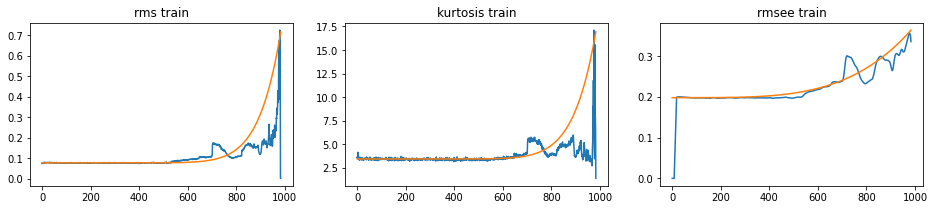

In [7]:
datas = ['rms', 'kurtosis', 'rmsee']

datasets['train']['rms']['ufrf'] = {}
datasets['train']['kurtosis']['ufrf'] = {}
datasets['train']['rmsee']['ufrf'] = {}

datasets['train']['rms']['ufrf']['data'] = []
datasets['train']['kurtosis']['ufrf']['data'] = []
datasets['train']['rmsee']['ufrf']['data'] = []

for i in range(len(datasets['train']['rms']['data'])):
    datasets['train']['rms']['ufrf']['data'].append(ufrf(i, 12.0917, 281.0209, 0.0773, 1.38e-5))
    datasets['train']['kurtosis']['ufrf']['data'].append(ufrf(i, 11.8280, 86.7537,  3.4471, 3.8e-10))
    datasets['train']['rmsee']['ufrf']['data'].append(ufrf(i, 5.0,  100.0, 0.19796, 3.55e-4))
    
datasets['train']['rms']['ufrf']['data'] = np.array(datasets['train']['rms']['ufrf']['data'])
datasets['train']['kurtosis']['ufrf']['data'] = np.array(datasets['train']['kurtosis']['ufrf']['data'])
datasets['train']['rmsee']['ufrf']['data'] = np.array(datasets['train']['rmsee']['ufrf']['data'])

fig, axs = plt.subplots(1, 3, figsize=((16, 3)))

for i in range(len(datas)):
    axs[i].plot(datasets['train'][datas[i]]['data'])
    axs[i].plot(datasets['train'][datas[i]]['ufrf']['data'])
    axs[i].set_title(datas[i] + ' train')

### Normalizações dos dados de treino

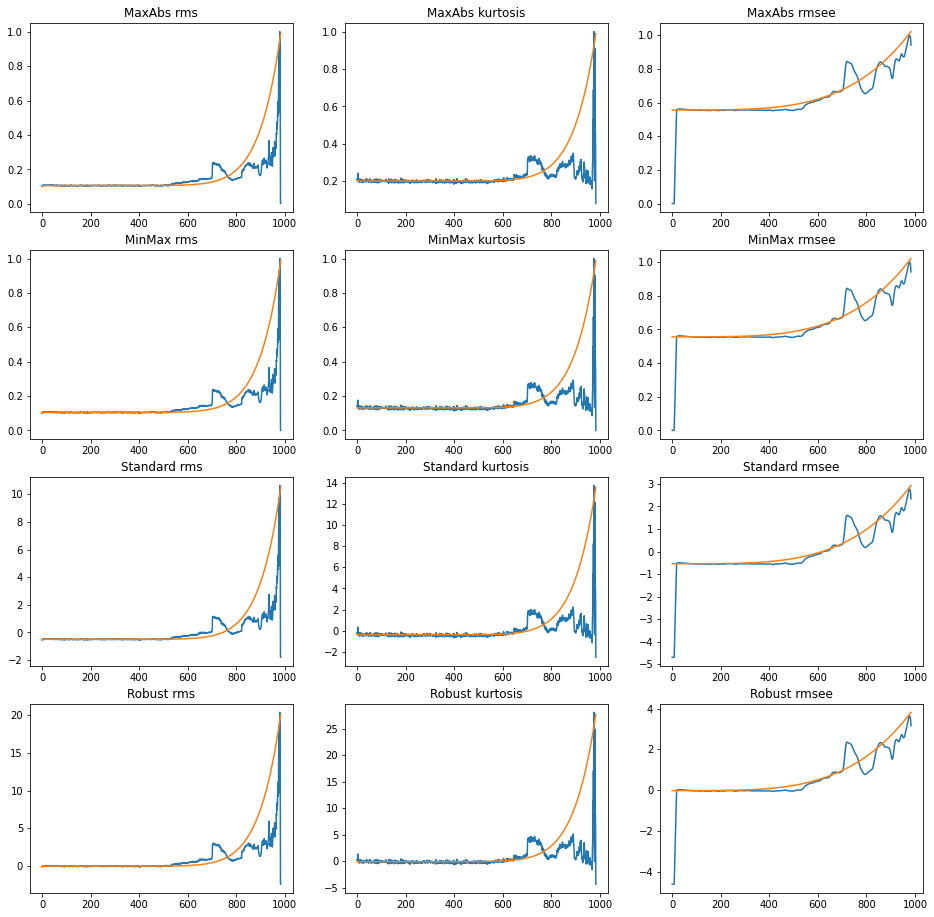

In [8]:
from sklearn.preprocessing import MaxAbsScaler, MinMaxScaler, StandardScaler, RobustScaler

keyed_scalers = [('MaxAbs', MaxAbsScaler), ('MinMax', MinMaxScaler), ('Standard', StandardScaler), ('Robust', RobustScaler)]
scalers = ['MaxAbs', 'MinMax', 'Standard', 'Robust']

for scaler_key, scaler in keyed_scalers:
    for key in datas:
        apply_normalization(datasets['train'][key], scaler_key, scaler())
        apply_fit_normalization(datasets['train'][key]['ufrf'], scaler_key, datasets['train'][key])

fig, axs = plt.subplots(4, 3, figsize=((16, 16)))
for i in range(len(datas)):
    for j in range(len(scalers)):
        axs[j][i].plot(datasets['train'][datas[i]][scalers[j]]['data'])
        axs[j][i].plot(datasets['train'][datas[i]]['ufrf'][scalers[j]]['data'])
        axs[j][i].set_title(scalers[j] + ' ' + datas[i])

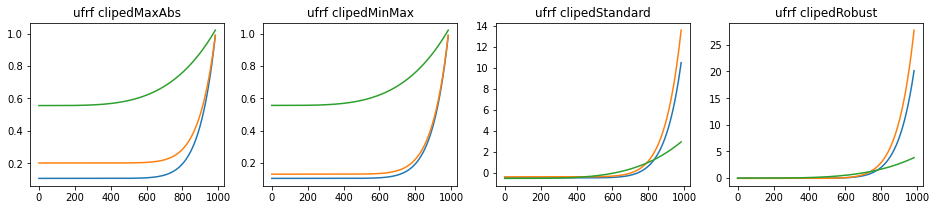

In [9]:
fig, axs = plt.subplots(1, 4, figsize=((16, 3)))

for i in range(len(scalers)):
    axs[i].plot(datasets['train']['rms']['ufrf'][scalers[i]]['data'])
    axs[i].plot(datasets['train']['kurtosis']['ufrf'][scalers[i]]['data'])
    axs[i].plot(datasets['train']['rmsee']['ufrf'][scalers[i]]['data'])
    axs[i].set_title('ufrf cliped' + scalers[i])

### Entre 0.0 e 1.0

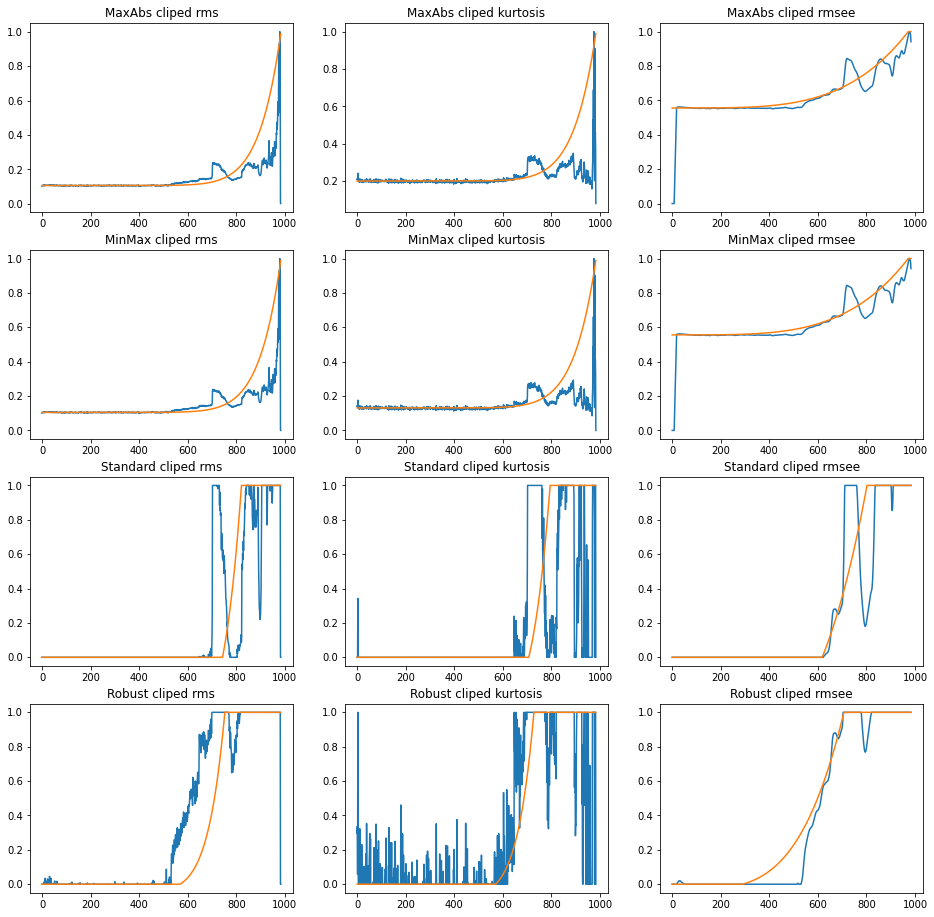

In [10]:
for scaler_key in scalers:
    for key in datas:
        datasets['train'][key][scaler_key + '_Cliped'] = {}
        datasets['train'][key][scaler_key + '_Cliped']['data'] = clip(datasets['train'][key][scaler_key]['data'])
        datasets['train'][key]['ufrf'][scaler_key + '_Cliped'] = {}
        datasets['train'][key]['ufrf'][scaler_key + '_Cliped']['data'] = clip(datasets['train'][key]['ufrf'][scaler_key]['data'])
        
fig, axs = plt.subplots(4, 3, figsize=((16, 16)))
for i in range(len(datas)):
    for j in range(len(scalers)):
        axs[j][i].plot(datasets['train'][datas[i]][scalers[j] + '_Cliped']['data'])
        axs[j][i].plot(datasets['train'][datas[i]]['ufrf'][scalers[j] + '_Cliped']['data'])
        axs[j][i].set_title(scalers[j] + ' cliped ' + datas[i])

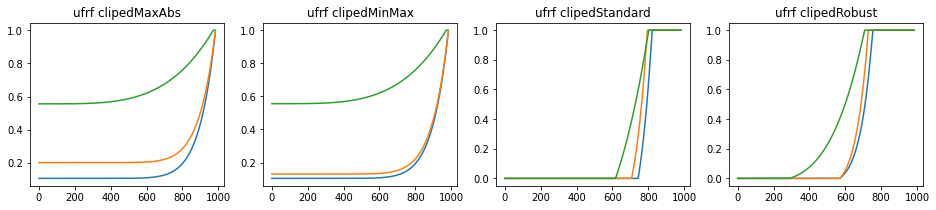

In [11]:
fig, axs = plt.subplots(1, 4, figsize=((16, 3)))

for i in range(len(scalers)):
    axs[i].plot(datasets['train']['rms']['ufrf'][scalers[i] + '_Cliped']['data'])
    axs[i].plot(datasets['train']['kurtosis']['ufrf'][scalers[i] + '_Cliped']['data'])
    axs[i].plot(datasets['train']['rmsee']['ufrf'][scalers[i] + '_Cliped']['data'])
    axs[i].set_title('ufrf cliped' + scalers[i])

### Zoom

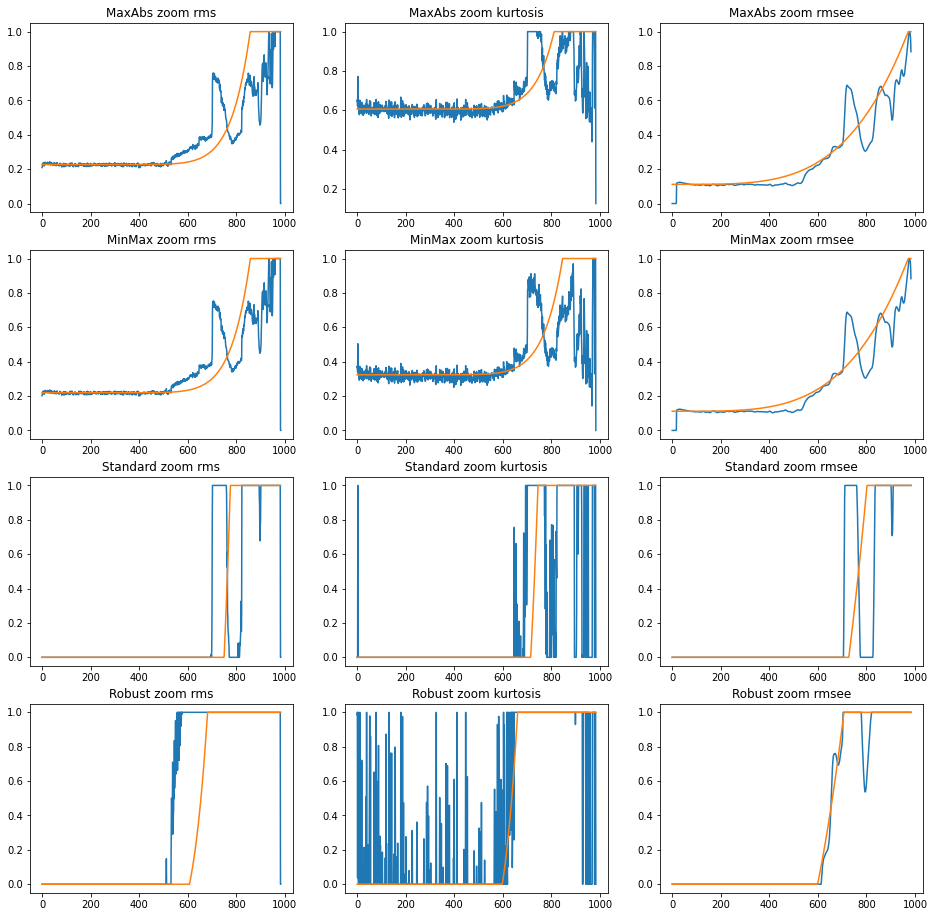

In [12]:
for scaler_key in scalers:
    for key in datas:
        datasets['train'][key][scaler_key + '_Zoom'] = {}
        datasets['train'][key][scaler_key + '_Zoom']['data'] = clip(datasets['train'][key][scaler_key]['data'], init = 0.5 if key == 'rmsee' else 0.05, end = 1.0 if key == 'rmsee' else 0.3)
        datasets['train'][key]['ufrf'][scaler_key + '_Zoom'] = {}
        datasets['train'][key]['ufrf'][scaler_key + '_Zoom']['data'] = clip(datasets['train'][key]['ufrf'][scaler_key]['data'], init = 0.5 if key == 'rmsee' else 0.05, end = 1.0 if key == 'rmsee' else 0.3)
        
fig, axs = plt.subplots(4, 3, figsize=((16, 16)))
for i in range(len(datas)):
    for j in range(len(scalers)):
        axs[j][i].plot(datasets['train'][datas[i]][scalers[j] + '_Zoom']['data'])
        axs[j][i].plot(datasets['train'][datas[i]]['ufrf'][scalers[j] + '_Zoom']['data'])
        axs[j][i].set_title(scalers[j] + ' zoom ' + datas[i])

## Extraindo dados de validação

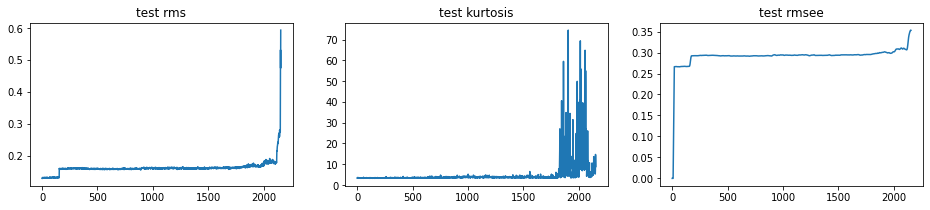

In [13]:
datasets['test'] = {}

datasets['test']['rms'] = {}
datasets['test']['kurtosis'] = {}
datasets['test']['rmsee'] = {}

datasets['test']['rms']['data'], datasets['test']['kurtosis']['data'], datasets['test']['rmsee']['data'] = extract_data('./1st_test/', 4)

fig, axs = plt.subplots(1, 3, figsize=((16, 3)))

for i in range(len(datas)):
    axs[i].plot(datasets['test'][datas[i]]['data'])
    axs[i].set_title('test ' + datas[i])

### Normalização dos dados de validação

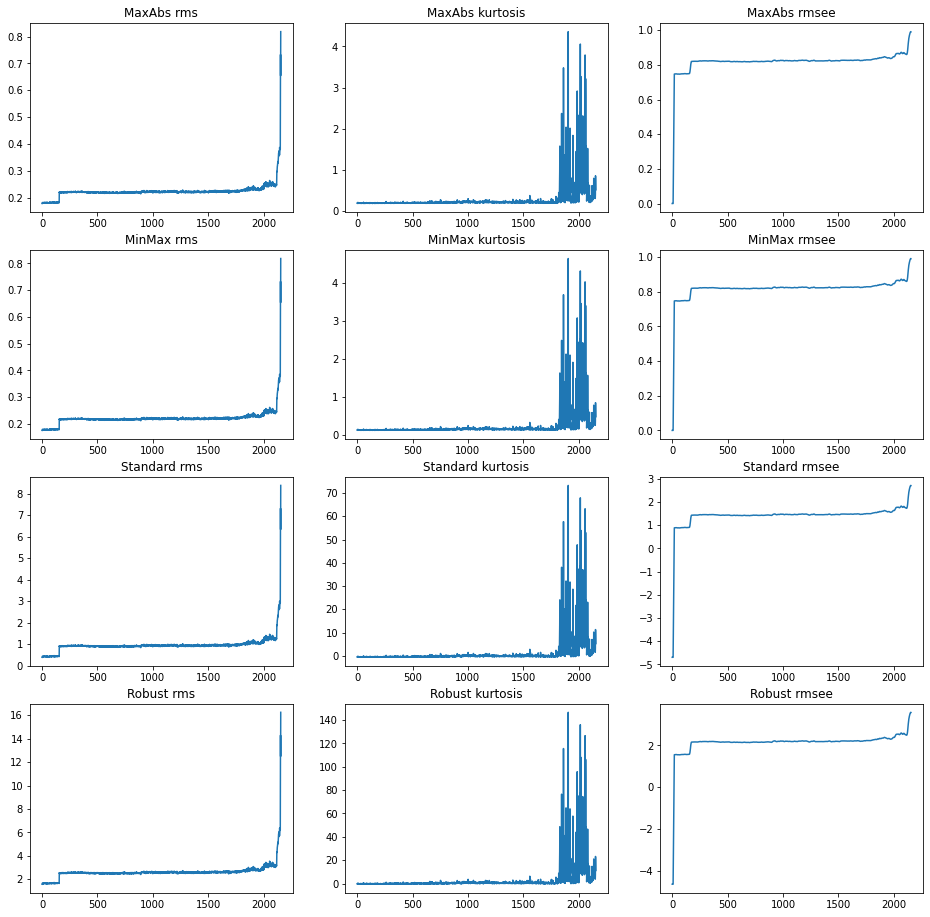

In [14]:
for scaler_key, scaler in keyed_scalers:
    for key in datas:
        apply_fit_normalization(datasets['test'][key], scaler_key, datasets['train'][key])

fig, axs = plt.subplots(4, 3, figsize=((16, 16)))
for i in range(len(datas)):
    for j in range(len(scalers)):
        axs[j][i].plot(datasets['test'][datas[i]][scalers[j]]['data'])
        axs[j][i].set_title(scalers[j] + ' ' + datas[i])

### Entre 0.0 e 1.0

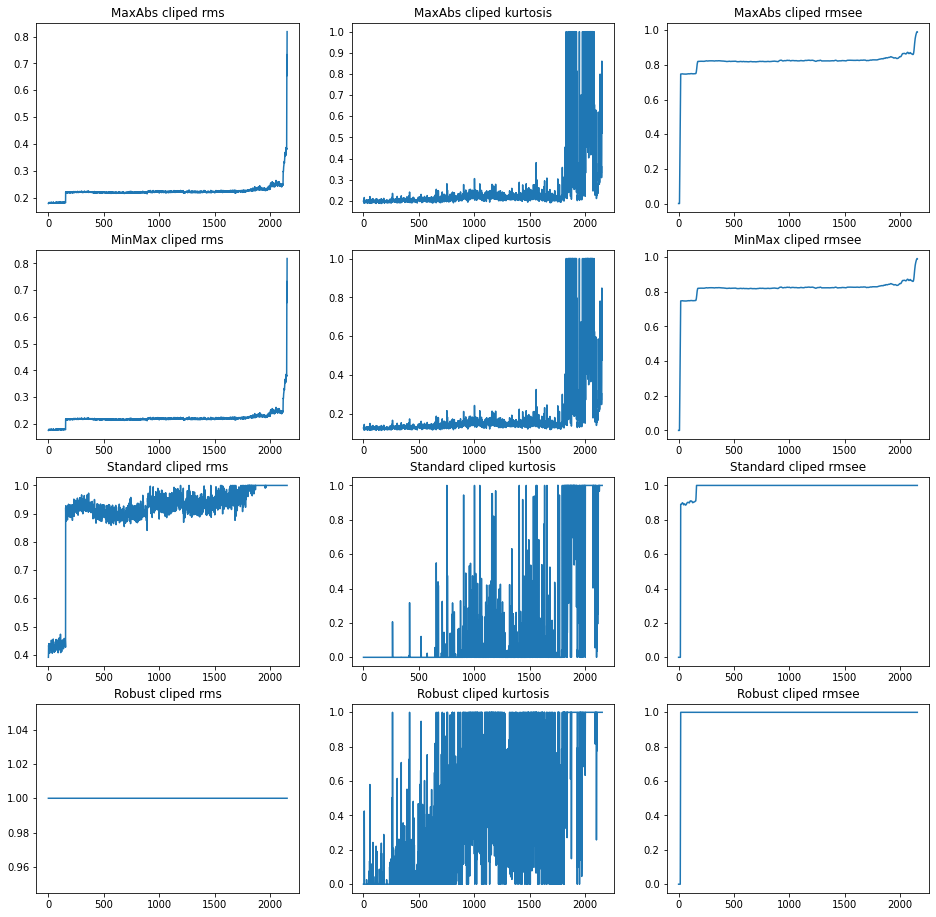

In [15]:
for scaler_key in scalers:
    for key in datas:
        datasets['test'][key][scaler_key + '_Cliped'] = {}
        datasets['test'][key][scaler_key + '_Cliped']['data'] = clip(datasets['test'][key][scaler_key]['data'])
        
fig, axs = plt.subplots(4, 3, figsize=((16, 16)))
for i in range(len(datas)):
    for j in range(len(scalers)):
        axs[j][i].plot(datasets['test'][datas[i]][scalers[j] + '_Cliped']['data'])
        axs[j][i].set_title(scalers[j] + ' cliped ' + datas[i])

### Zoom

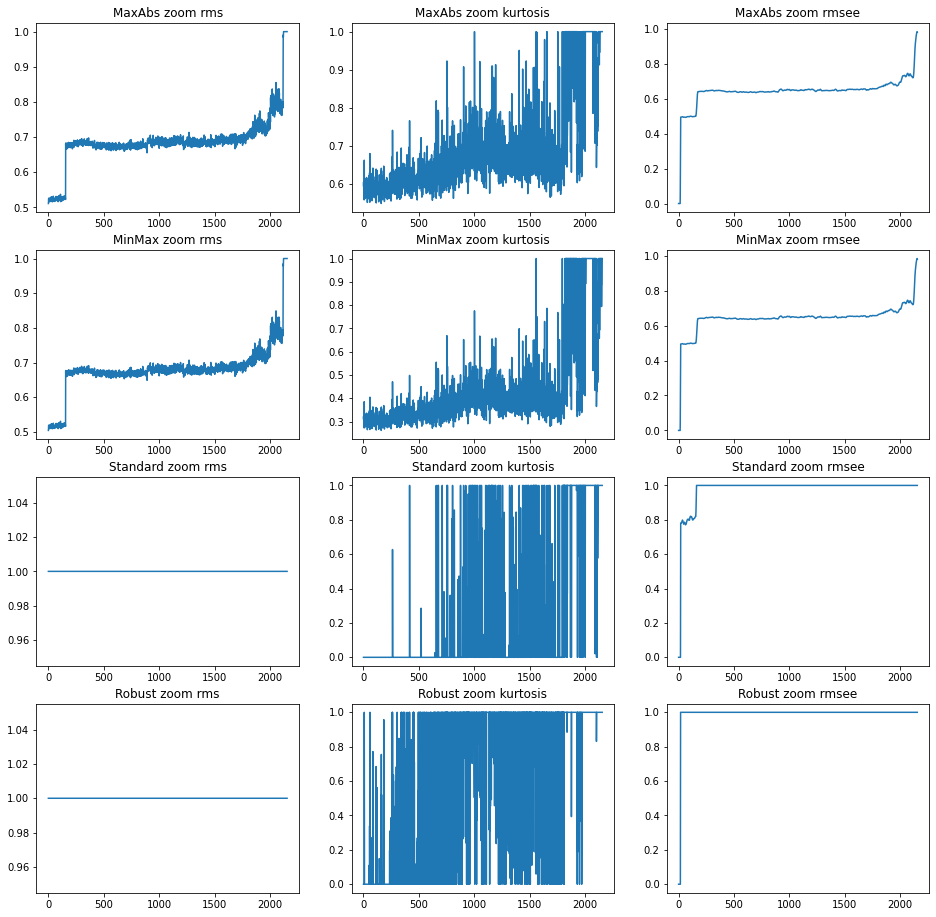

In [16]:
for scaler_key in scalers:
    for key in datas:
        datasets['test'][key][scaler_key + '_Zoom'] = {}
        datasets['test'][key][scaler_key + '_Zoom']['data'] = clip(datasets['test'][key][scaler_key]['data'], init = 0.5 if key == 'rmsee' else 0.05, end = 1.0 if key == 'rmsee' else 0.3)
        
fig, axs = plt.subplots(4, 3, figsize=((16, 16)))
for i in range(len(datas)):
    for j in range(len(scalers)):
        axs[j][i].plot(datasets['test'][datas[i]][scalers[j] + '_Zoom']['data'])
        axs[j][i].set_title(scalers[j] + ' zoom ' + datas[i])

## Centralizando o padrão de operação

### Treino

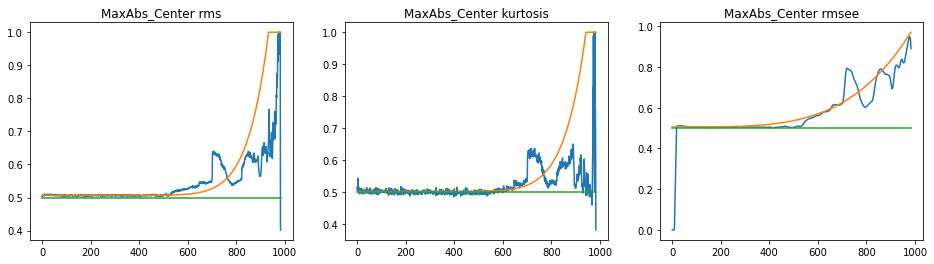

In [17]:
datasets['train']['rms']['MaxAbs_Center'] = {}
datasets['train']['rms']['MaxAbs_Center']['data'] = clip(datasets['train']['rms']['MaxAbs']['data'] + 0.4)
datasets['train']['kurtosis']['MaxAbs_Center'] = {}
datasets['train']['kurtosis']['MaxAbs_Center']['data'] = clip(datasets['train']['kurtosis']['MaxAbs']['data'] + 0.3)
datasets['train']['rmsee']['MaxAbs_Center'] = {}
datasets['train']['rmsee']['MaxAbs_Center']['data'] = clip(datasets['train']['rmsee']['MaxAbs']['data'] - 0.05)
datasets['train']['rms']['ufrf']['MaxAbs_Center'] = {}
datasets['train']['rms']['ufrf']['MaxAbs_Center']['data'] = clip(datasets['train']['rms']['ufrf']['MaxAbs']['data'] + 0.4)
datasets['train']['kurtosis']['ufrf']['MaxAbs_Center'] = {}
datasets['train']['kurtosis']['ufrf']['MaxAbs_Center']['data'] = clip(datasets['train']['kurtosis']['ufrf']['MaxAbs']['data'] + 0.3)
datasets['train']['rmsee']['ufrf']['MaxAbs_Center'] = {}
datasets['train']['rmsee']['ufrf']['MaxAbs_Center']['data'] = clip(datasets['train']['rmsee']['ufrf']['MaxAbs']['data'] - 0.05)

fig, axs = plt.subplots(1, 3, figsize=((16, 4)))
for i in range(len(datas)):
    for j in range(len(['MaxAbs_Center'])):
        axs[i].plot(datasets['train'][datas[i]]['MaxAbs_Center']['data'])
        axs[i].plot(datasets['train'][datas[i]]['ufrf']['MaxAbs_Center']['data'])
        line = []
        for _ in range(len(datasets['train'][datas[i]]['MaxAbs_Center']['data'])):
            line.append(0.5)
        axs[i].plot(line)
        axs[i].set_title('MaxAbs_Center' + ' ' + datas[i])

### Validação

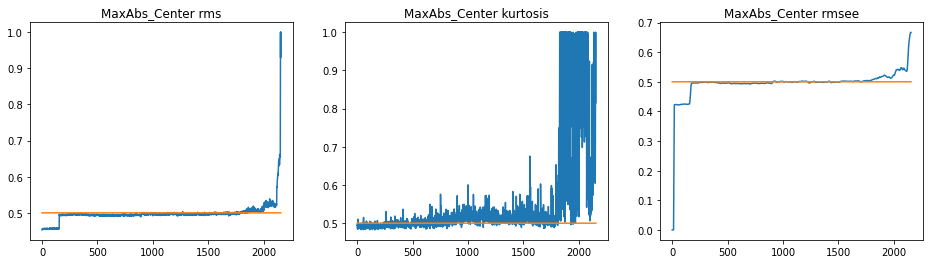

In [18]:
datasets['test']['rms']['MaxAbs_Center'] = {}
datasets['test']['rms']['MaxAbs_Center']['data'] = clip(datasets['test']['rms']['MaxAbs']['data'] + 0.275)
datasets['test']['kurtosis']['MaxAbs_Center'] = {}
datasets['test']['kurtosis']['MaxAbs_Center']['data'] = clip(datasets['test']['kurtosis']['MaxAbs']['data'] + 0.295)
datasets['test']['rmsee']['MaxAbs_Center'] = {}
datasets['test']['rmsee']['MaxAbs_Center']['data'] = clip(datasets['test']['rmsee']['MaxAbs']['data'] - 0.325)

fig, axs = plt.subplots(1, 3, figsize=((16, 4)))
for i in range(len(datas)):
    for j in range(len(['MaxAbs_Center'])):
        axs[i].plot(datasets['test'][datas[i]]['MaxAbs_Center']['data'])
        line = []
        for _ in range(len(datasets['test'][datas[i]]['MaxAbs_Center']['data'])):
            line.append(0.5)
        axs[i].plot(line)
        axs[i].set_title('MaxAbs_Center' + ' ' + datas[i])

## Extraindo dados de validação 2

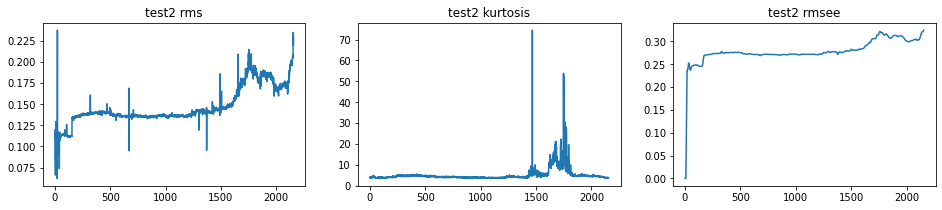

In [19]:
datasets['test2'] = {}

datasets['test2']['rms'] = {}
datasets['test2']['kurtosis'] = {}
datasets['test2']['rmsee'] = {}

datasets['test2']['rms']['data'], datasets['test2']['kurtosis']['data'], datasets['test2']['rmsee']['data'] = extract_data('./1st_test/', 6)

fig, axs = plt.subplots(1, 3, figsize=((16, 3)))

for i in range(len(datas)):
    axs[i].plot(datasets['test2'][datas[i]]['data'])
    axs[i].set_title('test2 ' + datas[i])

### Normalizando dados de validação 2

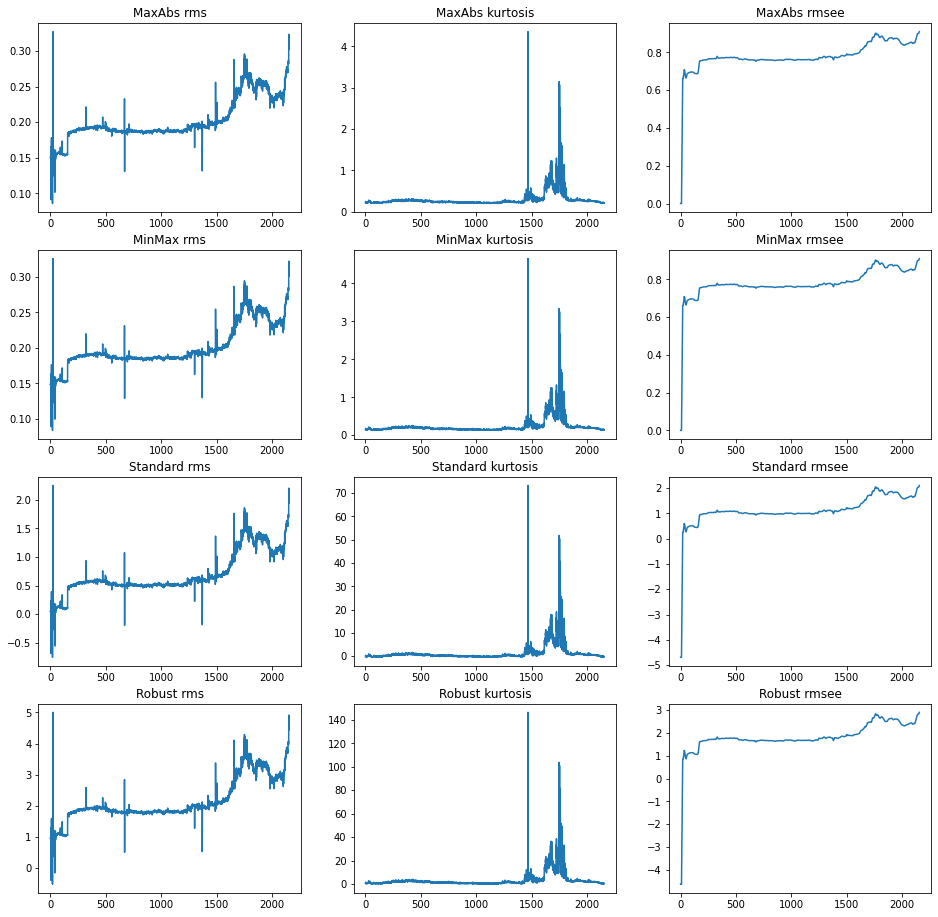

In [20]:
for scaler_key, scaler in keyed_scalers:
    for key in datas:
        apply_fit_normalization(datasets['test2'][key], scaler_key, datasets['train'][key])

fig, axs = plt.subplots(4, 3, figsize=((16, 16)))
for i in range(len(datas)):
    for j in range(len(scalers)):
        axs[j][i].plot(datasets['test2'][datas[i]][scalers[j]]['data'])
        axs[j][i].set_title(scalers[j] + ' ' + datas[i])

### Entre 0.0 e 1.0

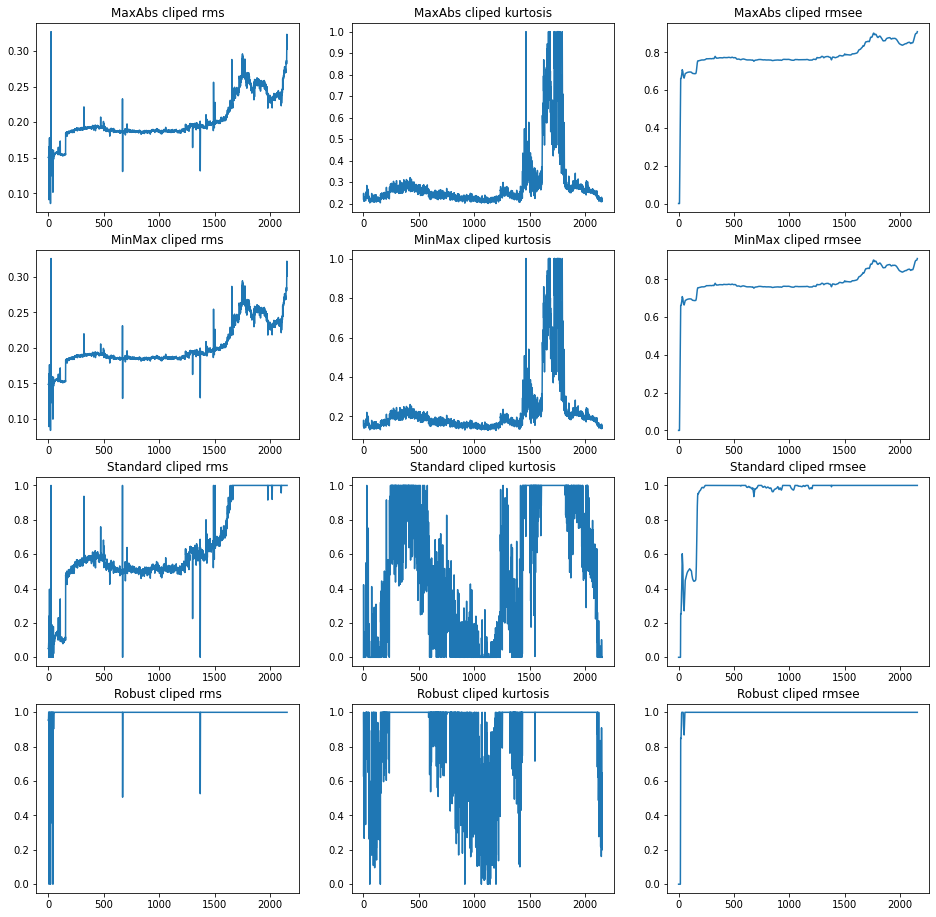

In [21]:
for scaler_key in scalers:
    for key in datas:
        datasets['test2'][key][scaler_key + '_Cliped'] = {}
        datasets['test2'][key][scaler_key + '_Cliped']['data'] = clip(datasets['test2'][key][scaler_key]['data'])
        
fig, axs = plt.subplots(4, 3, figsize=((16, 16)))
for i in range(len(datas)):
    for j in range(len(scalers)):
        axs[j][i].plot(datasets['test2'][datas[i]][scalers[j] + '_Cliped']['data'])
        axs[j][i].set_title(scalers[j] + ' cliped ' + datas[i])

# Treino

## SFAM - MaxAbs_Clipped

In [22]:
# import optuna

# def objective(trial):
#     alpha = trial.suggest_float("alpha", 1e-18, 1e+1, log=True)
#     rho = trial.suggest_float("rho", 1e-18, 1e+0, log=True)
#     beta = trial.suggest_float("beta", 1e-18, 1e+0, log=True)
#     uncommited_value = trial.suggest_float("uv", 0.5, 1.0, log=True)
    
#     sfam = SFAM(alpha = alpha, rho = rho, beta = beta, uncommited_value = uncommited_value)
#     sfam.train_nasa(lambda x: datasets['train'][x]['ufrf']['MaxAbs_Cliped']['data'], 392)
#     return sfam.predict_nasa(lambda x: datasets['train'][x]['MaxAbs_Cliped']['data'])

# study = optuna.create_study(direction='maximize')
# study.optimize(objective, n_trials=100)
# print(study.best_trial.params)

# # #Trial 112 finished with value: 0.3947100712105799 and parameters: {'rho': 3.2358034120332154e-05, 'uv': 0.9835112751325361, 'alpha': 2.7270781618220184e-06}. Best is trial 112 with value: 0.3947100712105799.
# # #Trial 188 finished with value: 0.40183112919633773 and parameters: {'rho': 0.9295486941424583, 'uv': 0.984398658226122, 'alpha': 2.2668089565117578e-07, 'beta': 0.9426549691910234}. Best is trial 188 with value: 0.40183112919633773.
# # #Trial 108 finished with value: 0.427263479145473 and parameters: {'rho': 0.0009686028049355828, 'uv': 0.9883119821455072, 'alpha': 4.084979094859232e-07, 'beta': 6.613883552322061e-05}. Best is trial 108 with value: 0.427263479145473.
# # #Trial 871 finished with value: 0.427263479145473 and parameters: {'alpha': 1.1167576673504459e-08, 'rho': 0.0005592497019541445, 'beta': 0.005437777540556062, 'uv': 0.989645864609353}. Best is trial 871 with value: 0.427263479145473.
# # #Best is trial 241 with value: 0.42929806714140384. {'alpha': 3.395245641548146e-11, 'rho': 4.3521380132425176e-08, 'beta': 2.3557187791365324e-07, 'uv': 0.9885496137738817}
# # #Best is trial 890 with value: 0.6866734486266531. {'alpha': 0.08704579858923452, 'rho': 1.5842446614486082e-12, 'beta': 0.02433635084039448, 'uv': 0.9480472449474258}
# # #Best is trial 164 with value: 0.7293997965412004. {'alpha': 0.45977710064840743, 'rho': 4.592646278009706e-13, 'beta': 6.62470116222985e-11, 'uv': 6.140198929780164e-11}
# # # Best is trial 106 with value: 0.7426246185147508. {'alpha': 1.2517591322643648e-16, 'rho': 1.5164290602975099e-15, 'beta': 0.03496236267182363, 'uv': 0.5249178974615589}
# # sfam['MaxAbs'] = SFAM(alpha = 4.6715861565370895e-14, rho = 3.4726756552458553e-10, beta = 4.688230591139349e-17, uncommited_value = 0.9739101209573398)
# # {'alpha': 2.617325177043259e-06, 'rho': 7.679082091677435e-12, 'beta': 0.035495950650972226, 'uv': 0.6868487573343112}

In [23]:
sfam = {}

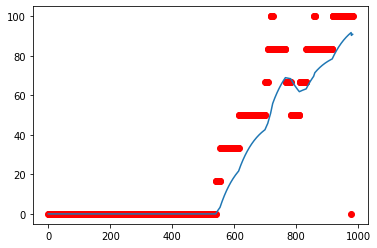

In [24]:
sfam['MaxAbs'] = SFAM(alpha = 2.617325177043259e-06, rho = 7.679082091677435e-12, beta = 0.035495950650972226, uncommited_value = 0.6868487573343112)

sfam['MaxAbs'].train_nasa(lambda x: datasets['train'][x]['ufrf']['MaxAbs_Cliped']['data'], 392)
sfam['MaxAbs'].predict_nasa(lambda x: datasets['train'][x]['MaxAbs']['data'], 392)
sfam['MaxAbs'].prune()

0.27842227378190254

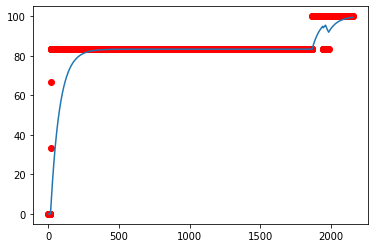

In [25]:
sfam['MaxAbs'].predict_nasa(lambda x: datasets['test'][x]['MaxAbs_Cliped']['data'])

## MLP - MaxAbs_Clipped

In [26]:
# import optuna

# def objective(trial):

#     n_layers = trial.suggest_int('n_layers', 1, 6)
#     layers = []
#     for i in range(n_layers):
#         layers.append(trial.suggest_int(f'n_units_{i}', 1, 200))

#     activation = trial.suggest_categorical('activation', ['identity', 'logistic', 'tanh', 'relu'])
#     solver = trial.suggest_categorical('solver', ['lbfgs', 'sgd', 'adam'])
#     alpha = trial.suggest_float("alpha", 1e-18, 1e+0, log=True)
    
#     if solver == 'sgd':
#         learning_rate = trial.suggest_categorical('learning_rate', ['constant', 'invscaling', 'adaptive'])
#         momentum = trial.suggest_float("momentum", 1e-18, 1e+0, log=True)
#     else:
#         learning_rate = 'constant'
#         momentum = 0.9
        
#     if solver == 'adam':
#         beta_1 = trial.suggest_float("beta_1", 1e-18, 1e+0, log=True)
#         beta_2 = trial.suggest_float("beta_2", 1e-18, 1e+0, log=True)
#     else:
#         beta_1 = 0.9
#         beta_2 = 0.999
    
    
#     clf = MLPClassifier(hidden_layer_sizes=tuple(layers), activation = activation, solver=solver, beta_1 = beta_1, beta_2 = beta_2, learning_rate = learning_rate, momentum = momentum, random_state = 0)
#     x_train, y_train = organize_nasa(lambda x: datasets['train'][x]['ufrf']['MaxAbs_Cliped']['data'], 392)
#     x_val, y_val = organize_nasa(lambda x: datasets['test'][x]['MaxAbs_Cliped']['data'])
    
#     clf.fit(x_train, y_train)
#     return clf.score(x_val, y_val)

# study = optuna.create_study(direction='maximize')
# study.optimize(objective, n_trials=100)
# print(study.best_trial.params)
# #Best is trial 141 with value: 0.7568667344862665. {'n_layers': 2, 'n_units_0': 1, 'n_units_1': 87, 'activation': 'tanh', 'solver': 'lbfgs', 'alpha': 6.800537599344594e-16}

0.6541200406917599

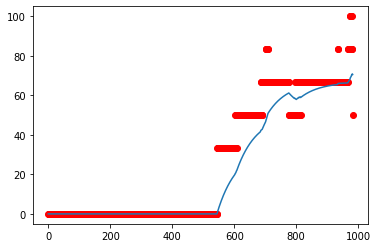

In [27]:
mlp = {}
mlp['MaxAbs'] = MLPClassifier(hidden_layer_sizes=(186, 42, 193, 189, 135, 145), activation = 'identity', solver='adam', alpha = 1.2049123869661849e-12, beta_1= 8.660310409635591e-05, beta_2= 0.013736105687331128, random_state = 0)

x_train, y_train = organize_nasa(lambda x: datasets['train'][x]['ufrf']['MaxAbs_Cliped']['data'], 392)
x_val, y_val = organize_nasa(lambda x: datasets['train'][x]['MaxAbs_Cliped']['data'], 392)
mlp['MaxAbs'].fit(x_train, y_train)

p = np.array(mlp['MaxAbs'].predict(x_val)) * (100.0 / 6.0)

plt.plot(p, 'ro')
plt.plot(smoothing(p))
mlp['MaxAbs'].score(x_val, y_val)

0.162877030162413

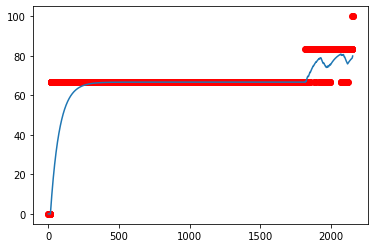

In [28]:
x_test, y_test = organize_nasa(lambda x: datasets['test'][x]['MaxAbs_Cliped']['data'])
p = np.array(mlp['MaxAbs'].predict(x_test)) * (100.0 / 6.0)

plt.plot(p, 'ro')
plt.plot(smoothing(p))
mlp['MaxAbs'].score(x_test, y_test)

## SFAM - MaxABs_Center

In [29]:
# import optuna

# def objective(trial):
#     alpha = trial.suggest_float("alpha", 1e-18, 1e+1, log=True)
#     rho = trial.suggest_float("rho", 1e-18, 1e+0, log=True)
#     beta = trial.suggest_float("beta", 1e-18, 1e+0, log=True)
#     uncommited_value = trial.suggest_float("uv", 0.5, 1e+0, log=True)
    
#     sfam = SFAM(alpha = alpha, rho = rho, beta = beta, uncommited_value = uncommited_value)
#     sfam.train_nasa(lambda x: datasets['train'][x]['ufrf']['MaxAbs_Center']['data'], 392)
#     return sfam.predict_nasa(lambda x: datasets['train'][x]['MaxAbs_Center']['data'], 392, False)

# study = optuna.create_study(direction='maximize')
# study.optimize(objective, n_trials=250)
# print(study.best_trial.params)
# # Best is trial 616 with value: 0.4008138351983723. {'alpha': 1.481329512950453e-10, 'rho': 3.693479376150351e-12, 'beta': 4.149916915933312e-09, 'uv': 0.9848333333556476}
# # Best is trial 466 with value: 0.7039674465920651. {'alpha': 5.622048313518151e-13, 'rho': 8.151965761257136e-09, 'beta': 5.763877184354314e-16, 'uv': 0.9924770110389107}


0.7375381485249237

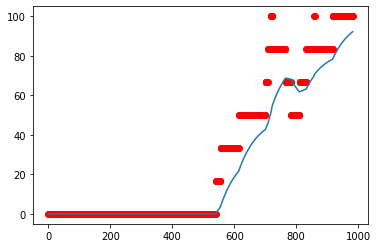

In [30]:
sfam['MaxAbs_Center'] = SFAM(alpha = 1.2932349835971422e-15, rho = 5.112297845240373e-12, beta = 0.036769828903903894, uncommited_value = 0.7552986535083299)

sfam['MaxAbs_Center'].train_nasa(lambda x: datasets['train'][x]['ufrf']['MaxAbs_Center']['data'], 392)
sfam['MaxAbs_Center'].predict_nasa(lambda x: datasets['train'][x]['MaxAbs_Center']['data'], 392)

0.09976798143851508

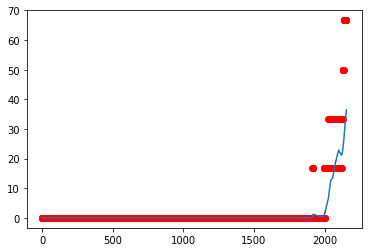

In [31]:
sfam['MaxAbs_Center'].predict_nasa(lambda x: datasets['test'][x]['MaxAbs_Center']['data'])

## MLP - MaxAbs_Center

In [32]:
# import optuna

# def objective(trial):

#     n_layers = trial.suggest_int('n_layers', 1, 6)
#     layers = []
#     for i in range(n_layers):
#         layers.append(trial.suggest_int(f'n_units_{i}', 1, 200))

#     activation = trial.suggest_categorical('activation', ['identity', 'logistic', 'tanh', 'relu'])
#     solver = trial.suggest_categorical('solver', ['lbfgs', 'sgd', 'adam'])
#     alpha = trial.suggest_float("alpha", 1e-18, 1e+0, log=True)
    
#     if solver == 'sgd':
#         learning_rate = trial.suggest_categorical('learning_rate', ['constant', 'invscaling', 'adaptive'])
#         momentum = trial.suggest_float("momentum", 1e-18, 1e+0, log=True)
#     else:
#         learning_rate = 'constant'
#         momentum = 0.9
        
#     if solver == 'adam':
#         beta_1 = trial.suggest_float("beta_1", 1e-18, 1e+0, log=True)
#         beta_2 = trial.suggest_float("beta_2", 1e-18, 1e+0, log=True)
#     else:
#         beta_1 = 0.9
#         beta_2 = 0.999
    
    
#     clf = MLPClassifier(hidden_layer_sizes=tuple(layers), activation = activation, solver=solver, beta_1 = beta_1, beta_2 = beta_2, learning_rate = learning_rate, momentum = momentum, random_state = 0)
#     x_train, y_train = organize_nasa(lambda x: datasets['train'][x]['ufrf']['MaxAbs_Center']['data'], 392)
#     x_val, y_val = organize_nasa(lambda x: datasets['train'][x]['MaxAbs_Center']['data'], 392)
    
#     clf.fit(x_train, y_train)
#     return clf.score(x_val, y_val)

# study = optuna.create_study(direction='maximize')
# study.optimize(objective, n_trials=200)
# print(study.best_trial.params)

# # #mlp['MaxAbs_Center'] = MLPClassifier(hidden_layer_sizes=(141, 84, 95, 22, 104), activation = 'relu', solver='adam')


0.6917599186164801

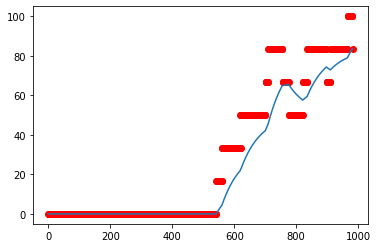

In [33]:
mlp = {}
mlp['MaxAbs_Center'] = MLPClassifier(hidden_layer_sizes=(110, 90, 92, 170, 66), activation = 'identity', solver='lbfgs', alpha = 7.793279570750885e-10, random_state = 0)

x_train, y_train = organize_nasa(lambda x: datasets['train'][x]['ufrf']['MaxAbs_Center']['data'], 392)
x_val, y_val = organize_nasa(lambda x: datasets['train'][x]['MaxAbs_Center']['data'], 392)
mlp['MaxAbs_Center'].fit(x_train, y_train)

p = np.array(mlp['MaxAbs_Center'].predict(x_val)) * (100.0 / 6.0)

plt.plot(p, 'ro')
plt.plot(smoothing(p))
mlp['MaxAbs_Center'].score(x_val, y_val)

0.09976798143851508

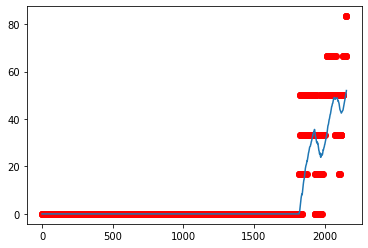

In [34]:
x_test, y_test = organize_nasa(lambda x: datasets['test'][x]['MaxAbs_Center']['data'])
p = np.array(mlp['MaxAbs_Center'].predict(x_test)) * (100.0 / 6.0)

plt.plot(p, 'ro')
plt.plot(smoothing(p))
mlp['MaxAbs_Center'].score(x_test, y_test)

## SFAM - MaxAbs_Zoom

In [ ]:
# import optuna

# def objective(trial):
#     alpha = trial.suggest_float("alpha", 1e-18, 1e+1, log=True)
#     rho = trial.suggest_float("rho", 1e-18, 1e+0, log=True)
#     beta = trial.suggest_float("beta", 1e-18, 1e+0, log=True)
#     uncommited_value = trial.suggest_float("uv", 0.5, 1.0, log=True)
    
#     sfam = SFAM(alpha = alpha, rho = rho, beta = beta, uncommited_value = uncommited_value)
#     sfam.train_nasa(lambda x: datasets['train'][x]['ufrf']['MaxAbs_Zoom']['data'], 392)
#     return sfam.predict_nasa(lambda x: datasets['train'][x]['MaxAbs_Zoom']['data'], 392)

# study = optuna.create_study(direction='maximize')
# study.optimize(objective, n_trials=100)
# print(study.best_trial.params)

# # Best is trial 106 with value: 0.7426246185147508. {'alpha': 8.711044148724726e-15, 'rho': 1.651959726556269e-05, 'beta': 0.03556285811793728, 'uv': 0.622653730160301}
# # 0.7507629704984741 SFAM(alpha = 7.614130239297938e-16, rho = 0.0368073300339664, beta = 0.018306735816381994, uncommited_value = 0.860340588623127)

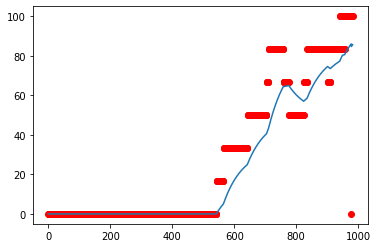

In [36]:
sfam['MaxAbs_Zoom'] = SFAM(alpha = 1.1661840026962726, rho = 2.7052884043004445e-05, beta = 0.8725909192315182, uncommited_value = 0.8909178357025973)

sfam['MaxAbs_Zoom'].train_nasa(lambda x: datasets['train'][x]['ufrf']['MaxAbs_Zoom']['data'], 392)
sfam['MaxAbs_Zoom'].predict_nasa(lambda x: datasets['train'][x]['MaxAbs_Zoom']['data'], 392)
sfam['MaxAbs_Zoom'].prune()

0.1716937354988399

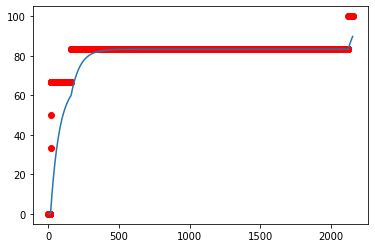

In [37]:
sfam['MaxAbs_Zoom'].predict_nasa(lambda x: datasets['test'][x]['MaxAbs_Zoom']['data'])

## MLP - MaxAbs_Zoom

In [38]:
# import optuna

# def objective(trial):

#     n_layers = trial.suggest_int('n_layers', 1, 6)
#     layers = []
#     for i in range(n_layers):
#         layers.append(trial.suggest_int(f'n_units_{i}', 1, 200))

#     activation = trial.suggest_categorical('activation', ['identity', 'logistic', 'tanh', 'relu'])
#     solver = trial.suggest_categorical('solver', ['lbfgs', 'sgd', 'adam'])
#     alpha = trial.suggest_float("alpha", 1e-18, 1e+0, log=True)
    
#     if solver == 'sgd':
#         learning_rate = trial.suggest_categorical('learning_rate', ['constant', 'invscaling', 'adaptive'])
#         momentum = trial.suggest_float("momentum", 1e-18, 1e+0, log=True)
#     else:
#         learning_rate = 'constant'
#         momentum = 0.9
        
#     if solver == 'adam':
#         beta_1 = trial.suggest_float("beta_1", 1e-18, 1e+0, log=True)
#         beta_2 = trial.suggest_float("beta_2", 1e-18, 1e+0, log=True)
#     else:
#         beta_1 = 0.9
#         beta_2 = 0.999
    
    
#     clf = MLPClassifier(hidden_layer_sizes=tuple(layers), activation = activation, solver=solver, beta_1 = beta_1, beta_2 = beta_2, learning_rate = learning_rate, momentum = momentum, random_state = 0)
#     x_train, y_train = organize_nasa(lambda x: datasets['train'][x]['ufrf']['MaxAbs_Zoom']['data'], 392)
#     x_val, y_val = organize_nasa(lambda x: datasets['train'][x]['MaxAbs_Zoom']['data'], 392)
    
#     clf.fit(x_train, y_train)
#     return clf.score(x_val, y_val)

# study = optuna.create_study(direction='maximize')
# study.optimize(objective, n_trials=200)
# print(study.best_trial.params)

# # #mlp['MaxAbs_Center'] = MLPClassifier(hidden_layer_sizes=(141, 84, 95, 22, 104), activation = 'relu', solver='adam')


c:\users\projeto\appdata\local\programs\python\python38\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


0.7527975584944049

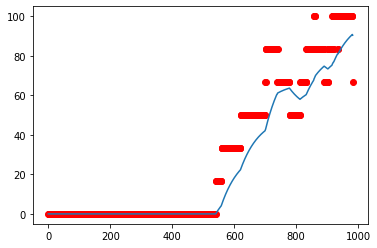

In [39]:
mlp['MaxAbs_Zoom'] = MLPClassifier(hidden_layer_sizes=(79, 124), activation = 'relu', solver='adam', alpha = 2.9734674750533706e-15, beta_1 = 2.092544907459088e-09, beta_2 = 0.4640112349610577, random_state = 0)

x_train, y_train = organize_nasa(lambda x: datasets['train'][x]['ufrf']['MaxAbs_Zoom']['data'], 392)
x_val, y_val = organize_nasa(lambda x: datasets['train'][x]['MaxAbs_Zoom']['data'], 392)
mlp['MaxAbs_Zoom'].fit(x_train, y_train)

p = np.array(mlp['MaxAbs_Zoom'].predict(x_val)) * (100.0 / 6.0)

plt.plot(p, 'ro')
plt.plot(smoothing(p))
mlp['MaxAbs_Zoom'].score(x_val, y_val)

0.11276102088167053

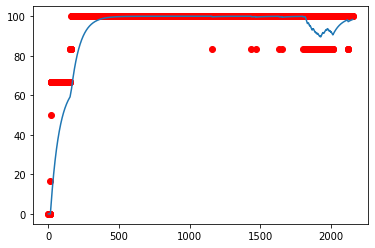

In [40]:
x_test, y_test = organize_nasa(lambda x: datasets['test'][x]['MaxAbs_Zoom']['data'])
p = np.array(mlp['MaxAbs_Zoom'].predict(x_test)) * (100.0 / 6.0)

plt.plot(p, 'ro')
plt.plot(smoothing(p))
mlp['MaxAbs_Zoom'].score(x_test, y_test)

# Treino variando ordem

## SFAM - MaxAbs_Cliped

In [41]:
# import optuna

# def objective(trial):
#     alpha = trial.suggest_float("alpha", 1e-18, 1e+1, log=True)
#     rho = trial.suggest_float("rho", 1e-18, 1e+0, log=True)
#     beta = trial.suggest_float("beta", 1e-18, 1e+0, log=True)
#     order = trial.suggest_int("order", 3, 25)
#     uncommited_value = trial.suggest_float("uv", 0.5, 1.0, log=True)
    
#     sfam = SFAM(input_size=3 * order, alpha = alpha, rho = rho, beta = beta, uncommited_value = uncommited_value)
#     sfam.train_nasa(lambda x: datasets['train'][x]['ufrf']['MaxAbs_Cliped']['data'], 392, order)
#     return sfam.predict_nasa(lambda x: datasets['train'][x]['MaxAbs_Cliped']['data'], 392, order)

# study = optuna.create_study(direction='maximize')
# study.optimize(objective, n_trials=100)
# print(study.best_trial.params)
# #Best is trial 56 with value: 0.7370030581039755. {'alpha': 1.901072353223224e-09, 'rho': 0.09435357495043345, 'beta': 0.04970296173592995, 'order': 4, 'uv': 0.8271269742914835}


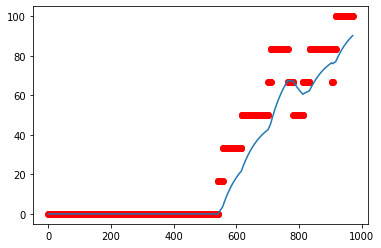

In [42]:
order = 13
sfam['MaxAbs_HOrder'] = SFAM(input_size=order * 3, alpha = 1.4937614035813953e-05, rho = 0.001602074207017527, beta = 0.09486927599859632, uncommited_value = 0.6703351329846337)

sfam['MaxAbs_HOrder'].train_nasa(lambda x: datasets['train'][x]['ufrf']['MaxAbs_Cliped']['data'], 392, order)
sfam['MaxAbs_HOrder'].predict_nasa(lambda x: datasets['train'][x]['MaxAbs_Cliped']['data'], 392, order)
sfam['MaxAbs_HOrder'].prune()

0.2332089552238806

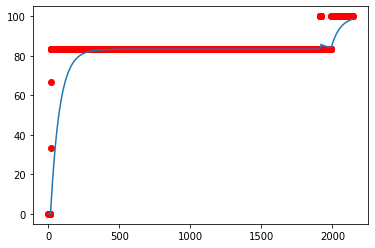

In [43]:
sfam['MaxAbs_HOrder'].predict_nasa(lambda x: datasets['test'][x]['MaxAbs_Cliped']['data'], -1, order)

## SFAM - MaxAbs_Center

In [44]:
# import optuna

# def objective(trial):
#     alpha = trial.suggest_float("alpha", 1e-18, 1e+1, log=True)
#     rho = trial.suggest_float("rho", 1e-18, 1e+0, log=True)
#     beta = trial.suggest_float("beta", 1e-18, 1e+0, log=True)
#     order = trial.suggest_int("order", 3, 25)
#     uncommited_value = trial.suggest_float("uv", 0.5, 1.0, log=True)
    
#     sfam = SFAM(input_size=3 * order, alpha = alpha, rho = rho, beta = beta, uncommited_value = uncommited_value)
#     sfam.train_nasa(lambda x: datasets['train'][x]['ufrf']['MaxAbs_Center']['data'], 392, order)
#     return sfam.predict_nasa(lambda x: datasets['train'][x]['MaxAbs_Center']['data'], 392, order)

# study = optuna.create_study(direction='maximize')
# study.optimize(objective, n_trials=100)
# print(study.best_trial.params)
# #Best is trial 89 with value: 0.7320328542094456. {'alpha': 3.664125890863213e-10, 'rho': 5.385562525240191e-13, 'beta': 0.06498813095645183, 'order': 11, 'uv': 0.7742260125177193}

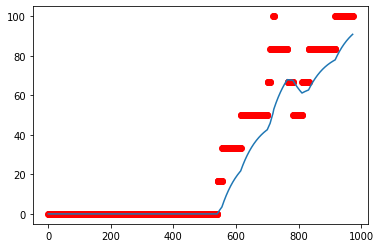

In [45]:
order = 11
sfam['MaxAbs_Center_HOrder'] = SFAM(input_size=order * 3, alpha = 3.664125890863213e-10, rho = 5.385562525240191e-13, beta = 0.06498813095645183, uncommited_value = 0.7742260125177193)

sfam['MaxAbs_Center_HOrder'].train_nasa(lambda x: datasets['train'][x]['ufrf']['MaxAbs_Center']['data'], 392, order)
sfam['MaxAbs_Center_HOrder'].predict_nasa(lambda x: datasets['train'][x]['MaxAbs_Center']['data'], 392, order)
sfam['MaxAbs_Center_HOrder'].prune()

0.09599254426840634

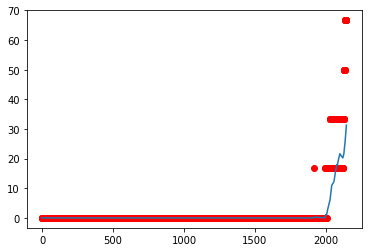

In [46]:
sfam['MaxAbs_Center_HOrder'].predict_nasa(lambda x: datasets['test'][x]['MaxAbs_Center']['data'], -1, order)

## SFAM - MaxAbs_Zoom

In [47]:
# import optuna

# def objective(trial):
#     alpha = trial.suggest_float("alpha", 1e-18, 1e+1, log=True)
#     rho = trial.suggest_float("rho", 1e-18, 1e+0, log=True)
#     beta = trial.suggest_float("beta", 1e-18, 1e+0, log=True)
#     order = trial.suggest_int("order", 3, 25)
#     uncommited_value = trial.suggest_float("uv", 0.5, 1.0, log=True)
    
#     sfam = SFAM(input_size=3 * order, alpha = alpha, rho = rho, beta = beta, uncommited_value = uncommited_value)
#     sfam.train_nasa(lambda x: datasets['train'][x]['ufrf']['MaxAbs_Zoom']['data'], 392, order)
#     return sfam.predict_nasa(lambda x: datasets['train'][x]['MaxAbs_Zoom']['data'], 392, order)

# study = optuna.create_study(direction='maximize')
# study.optimize(objective, n_trials=100)
# print(study.best_trial.params)


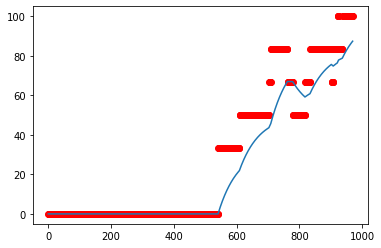

In [48]:
order = 14
sfam['MaxAbs_Zoom_HOrder'] = SFAM(input_size=order * 3, alpha = 0.49315860824457886, rho = 1.0329266002189683e-16, beta = 7.128032283404492e-14, uncommited_value = 0.5723724108474563)

sfam['MaxAbs_Zoom_HOrder'].train_nasa(lambda x: datasets['train'][x]['ufrf']['MaxAbs_Zoom']['data'], 392, order)
sfam['MaxAbs_Zoom_HOrder'].predict_nasa(lambda x: datasets['train'][x]['MaxAbs_Zoom']['data'], 392, order)
sfam['MaxAbs_Zoom_HOrder'].prune()

0.21791880541297245

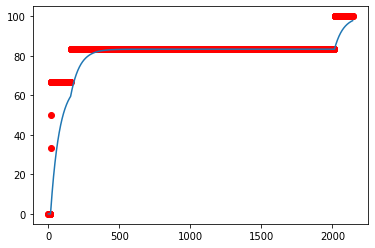

In [49]:
sfam['MaxAbs_Zoom_HOrder'].predict_nasa(lambda x: datasets['test'][x]['MaxAbs_Zoom']['data'], -1, order)

In [50]:
# import optuna

# def objective(trial):
#     alpha = trial.suggest_float("alpha", 1e-18, 1e+1, log=True)
#     rho = trial.suggest_float("rho", 1e-18, 1e+0, log=True)
#     beta = trial.suggest_float("beta", 1e-18, 1e+0, log=True)
#     order = trial.suggest_int("order", 3, 25)
#     uncommited_value = trial.suggest_float("uv", 0.5, 1.0, log=True)
    
#     sfam = SFAM(input_size=3 * order, alpha = alpha, rho = rho, beta = beta, uncommited_value = uncommited_value)
#     sfam.train_nasa(lambda x: datasets['train'][x]['ufrf']['MaxAbs_Cliped']['data'], 392, order)
#     return sfam.predict_nasa(lambda x: datasets['test'][x]['MaxAbs_Cliped']['data'], -1, order)

# study = optuna.create_study(direction='maximize')
# study.optimize(objective, n_trials=100)
# print(study.best_trial.params)


In [51]:
# import optuna

# def objective(trial):
#     alpha = trial.suggest_float("alpha", 1e-18, 1e+1, log=True)
#     rho = trial.suggest_float("rho", 1e-18, 1e+0, log=True)
#     beta = trial.suggest_float("beta", 1e-18, 1e+0, log=True)
#     order = trial.suggest_int("order", 3, 25)
#     uncommited_value = trial.suggest_float("uv", 0.5, 1.0, log=True)
    
#     sfam = SFAM(input_size=3 * order, alpha = alpha, rho = rho, beta = beta, uncommited_value = uncommited_value)
#     sfam.train_nasa(lambda x: datasets['train'][x]['MaxAbs_Cliped']['data'], 392, order)
#     return sfam.predict_nasa(lambda x: datasets['test'][x]['MaxAbs_Cliped']['data'], -1, order)

# study = optuna.create_study(direction='maximize')
# study.optimize(objective, n_trials=100)
# print(study.best_trial.params)


In [52]:
import optuna

def objective(trial):

    n_layers = trial.suggest_int('n_layers', 1, 6)
    layers = []
    for i in range(n_layers):
        layers.append(trial.suggest_int(f'n_units_{i}', 1, 200))

    activation = trial.suggest_categorical('activation', ['identity', 'logistic', 'tanh', 'relu'])
    solver = trial.suggest_categorical('solver', ['lbfgs', 'sgd', 'adam'])
    alpha = trial.suggest_float("alpha", 1e-18, 1e+0, log=True)
    
    if solver == 'sgd':
        learning_rate = trial.suggest_categorical('learning_rate', ['constant', 'invscaling', 'adaptive'])
        momentum = trial.suggest_float("momentum", 1e-18, 1e+0, log=True)
    else:
        learning_rate = 'constant'
        momentum = 0.9
        
    if solver == 'adam':
        beta_1 = trial.suggest_float("beta_1", 1e-18, 1e+0, log=True)
        beta_2 = trial.suggest_float("beta_2", 1e-18, 1e+0, log=True)
    else:
        beta_1 = 0.9
        beta_2 = 0.999
    
    order = trial.suggest_int("order", 3, 25)
    
    clf = MLPClassifier(hidden_layer_sizes=tuple(layers), activation = activation, solver=solver, beta_1 = beta_1, beta_2 = beta_2, learning_rate = learning_rate, momentum = momentum, random_state = 0)
    x_train, y_train = organize_nasa(lambda x: datasets['train'][x]['ufrf']['MaxAbs_Zoom']['data'], 392, order)
    x_val, y_val = organize_nasa(lambda x: datasets['train'][x]['MaxAbs_Zoom']['data'], 392, order)
    
    clf.fit(x_train, y_train)
    return clf.score(x_val, y_val)

study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=100)
print(study.best_trial.params)

# #mlp['MaxAbs_Center'] = MLPClassifier(hidden_layer_sizes=(141, 84, 95, 22, 104), activation = 'relu', solver='adam')


[I 2021-10-27 00:59:27,715] A new study created in memory with name: no-name-253fdade-7cb9-4302-b30a-bf814d7d6929
c:\users\projeto\appdata\local\programs\python\python38\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:549: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
[I 2021-10-27 00:59:34,425] Trial 0 finished with value: 0.6541666666666667 and parameters: {'n_layers': 5, 'n_units_0': 198, 'n_units_1': 145, 'n_units_2': 107, 'n_units_3': 22, 'n_units_4': 24, 'activation': 'tanh', 'solver': 'lbfgs', 'alpha': 3.732732568902895e-08, 'order': 25}. Best is trial 0 with value: 0.6541666666666667.
[I 2021-10-27 00:59:37,616] Trial 1 finished with value: 0.45769622833843016 and parameters: {'n_layers': 5, 'n_

[I 2021-10-27 01:00:14,799] Trial 16 finished with value: 0.7415730337078652 and parameters: {'n_layers': 3, 'n_units_0': 95, 'n_units_1': 115, 'n_units_2': 133, 'activation': 'identity', 'solver': 'lbfgs', 'alpha': 2.84990602480148e-11, 'order': 6}. Best is trial 16 with value: 0.7415730337078652.
[I 2021-10-27 01:00:17,410] Trial 17 finished with value: 0.7451181911613566 and parameters: {'n_layers': 3, 'n_units_0': 44, 'n_units_1': 111, 'n_units_2': 196, 'activation': 'identity', 'solver': 'lbfgs', 'alpha': 1.667569569243764e-10, 'order': 12}. Best is trial 17 with value: 0.7451181911613566.
[I 2021-10-27 01:00:22,652] Trial 18 finished with value: 0.7458847736625515 and parameters: {'n_layers': 3, 'n_units_0': 36, 'n_units_1': 200, 'n_units_2': 182, 'activation': 'identity', 'solver': 'lbfgs', 'alpha': 9.312309481398716e-11, 'order': 13}. Best is trial 18 with value: 0.7458847736625515.
[I 2021-10-27 01:00:24,270] Trial 19 finished with value: 0.7376543209876543 and parameters: {'n

c:\users\projeto\appdata\local\programs\python\python38\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:549: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
[I 2021-10-27 01:00:53,497] Trial 35 finished with value: 0.7392197125256673 and parameters: {'n_layers': 2, 'n_units_0': 60, 'n_units_1': 98, 'activation': 'logistic', 'solver': 'lbfgs', 'alpha': 3.236952006562639e-08, 'order': 11}. Best is trial 21 with value: 0.7502579979360166.
[I 2021-10-27 01:00:55,883] Trial 36 finished with value: 0.7203742203742204 and parameters: {'n_layers': 3, 'n_units_0': 37, 'n_units_1': 76, 'n_units_2': 164, 'activation': 'identity', 'solver': 'lbfgs', 'alpha': 4.894458394619109e-12, 'order': 23}. Best is trial 21 with 

[I 2021-10-27 01:01:33,754] Trial 52 finished with value: 0.7435897435897436 and parameters: {'n_layers': 3, 'n_units_0': 36, 'n_units_1': 155, 'n_units_2': 190, 'activation': 'identity', 'solver': 'lbfgs', 'alpha': 6.165941337976268e-08, 'order': 10}. Best is trial 21 with value: 0.7502579979360166.
c:\users\projeto\appdata\local\programs\python\python38\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:549: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
[I 2021-10-27 01:01:37,118] Trial 53 finished with value: 0.7548717948717949 and parameters: {'n_layers': 3, 'n_units_0': 47, 'n_units_1': 121, 'n_units_2': 200, 'activation': 'identity', 'solver': 'lbfgs', 'alpha': 1.4873677189530547e-06, 'order': 10}. B

[I 2021-10-27 01:01:52,871] Trial 71 finished with value: 0.7397119341563786 and parameters: {'n_layers': 3, 'n_units_0': 32, 'n_units_1': 133, 'n_units_2': 191, 'activation': 'identity', 'solver': 'lbfgs', 'alpha': 4.804372358339285e-12, 'order': 13}. Best is trial 55 with value: 0.7553735926305015.
[I 2021-10-27 01:01:54,074] Trial 72 finished with value: 0.7338129496402878 and parameters: {'n_layers': 3, 'n_units_0': 56, 'n_units_1': 109, 'n_units_2': 91, 'activation': 'identity', 'solver': 'lbfgs', 'alpha': 4.1026110031718564e-10, 'order': 12}. Best is trial 55 with value: 0.7553735926305015.
c:\users\projeto\appdata\local\programs\python\python38\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:549: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_op

c:\users\projeto\appdata\local\programs\python\python38\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:549: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
[I 2021-10-27 01:02:27,269] Trial 87 finished with value: 0.6858316221765913 and parameters: {'n_layers': 3, 'n_units_0': 27, 'n_units_1': 51, 'n_units_2': 170, 'activation': 'tanh', 'solver': 'lbfgs', 'alpha': 1.5697303960472947e-09, 'order': 11}. Best is trial 85 with value: 0.7579162410623085.
[I 2021-10-27 01:02:29,791] Trial 88 finished with value: 0.6935817805383023 and parameters: {'n_layers': 3, 'n_units_0': 35, 'n_units_1': 69, 'n_units_2': 179, 'activation': 'tanh', 'solver': 'adam', 'alpha': 7.82550929906451e-11, 'beta_1': 5.810190573872324

{'n_layers': 3, 'n_units_0': 28, 'n_units_1': 66, 'n_units_2': 168, 'activation': 'tanh', 'solver': 'lbfgs', 'alpha': 9.111187988931513e-09, 'order': 6}
